*updated 27 Jul 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 4303 "AI and Machine Learning in Marine Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES4303_ML_ocean) page.

---
# 2. Data splitting, scaling, model skill, and validations

This is one of the few cases where the material here is not completely self-contained, because otherwise this notebook becomes quite long and sidetracking quite a bit. You should refer to the lecture slides for the theoretical background.

The main moral of the story is that ***what you don't do in statistics you should not do in data-driven / ML methods***; see OCES 3301. Examples include:
1. Do lots of statistical trials and only report the one that gave you the result you want
2. Torturing the data until it confesses
3. You should cross validate and provide robustness checks
4. Design on how you obtain the data and how you clean the data is actually important
5. etc...

<img src="https://imgs.xkcd.com/comics/extrapolating.png" width="450" alt='extrapolating'>

Here we are going to demonstrate some aspects of what it says on the title, using linear regression and some of the `scikit-learn` interface.

> ## Key Objective(s)
> 1. Demonstrates utility and syntax of the `scikit-learn` package
> 2. Highlight some inherent randomness in data-driven methods
> 3. Given the above, highlight the need to evaluate robustness of model skill (which requires defining what is meant by "skill")

Going to load a whole load of basic things; specific parts of `scikit-learn` will be loaded when the topic comes up. I am going to demonstrate most of my points using the `penguin` data, so I also need `pandas` but just at the beginning (mostly copy and pasting some code from the last workshop).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES4303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


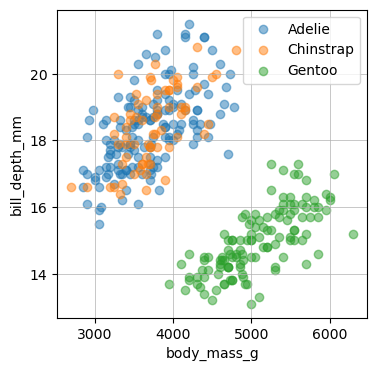

In [3]:
# do a 2d plot of two specific variables in the penguins data

target_vars = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
ind = [3, 1]

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
for species in np.sort(df["species"].unique()):   # pick out all unique entries under `species`
    ax.scatter(df[df["species"] == species][target_vars[ind[0]]], 
               df[df["species"] == species][target_vars[ind[1]]],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"{target_vars[ind[0]]}")
ax.set_ylabel(f"{target_vars[ind[1]]}")
ax.grid(lw=0.5, zorder=0)
ax.legend();

---
## a) Dataset splitting

The usual approach is to split the data into:

* ***training data***, which is passed in during model training
* ***testing data***, which is used to evalute the ***skill*** of a model (whatever you want skill to mean)
* ***validation data***, which is for tuning internal ***hyperparameters***, and is exposed to the model during training

Mostly going to deal with the first two. Two "obvious" (!?) questions to ask for the dataset splitting would mainly concern whether you want a specific selection, and how much data you want in each dataset. There is some arbitrariness in this and answer might be context dependent...

Without knowing what the data looks like, probably the most sensible thing to do is to just select data randomly (i.e. sampling from a uniform distribution). Doing a 80:20 training testing dataset split also seems reasonable. You can do this by hand, or use the `train_test_split` in `sklearn` to do this also. Below demostrates the syntax of that and provides some illustration of what is going on.

> NOTE: Below I've actually loaded the arrays into memory, but can actually pass in `pandas` arrays.

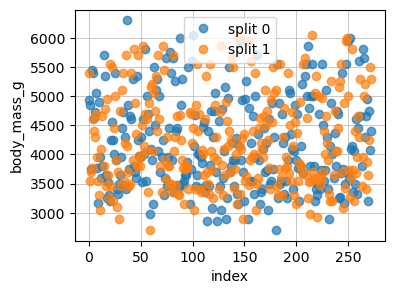

In [4]:
# train_test_split syntax demonstration
from sklearn.model_selection import train_test_split

# select data based on choice of "ind" above:
X = df[target_vars[ind[0]]].values  # actually load the data into memory

# going to subset data twice to demonstrate a point

fig = plt.figure(figsize=(4, 3))
ax = plt.axes()
for i in range(2):
    X_train, X_test = train_test_split(X, test_size=0.2) # 20% of data in test
    ax.plot(X_train, f'C{i}o', alpha=0.7, label=f"split {i}")
ax.set_xlabel("index")
ax.set_ylabel(f"{target_vars[ind[0]]}")
ax.grid(lw=0.5, zorder=0)
ax.legend();

It's not that clear above, but the splitting is random and the data selected is not completely overlapping. It's probably clearer in the case where I select two variables and do this as a scatter plot. The below code demonstrates also how you can pass in multiple arrays to be split.

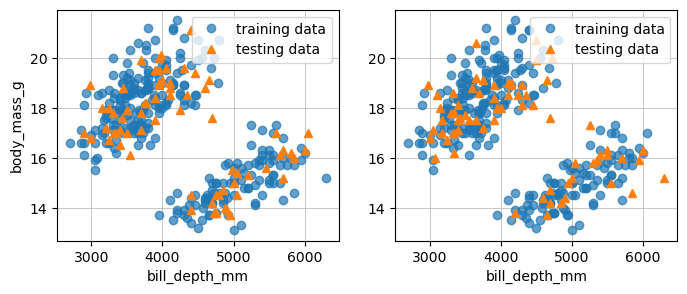

In [5]:
# select data based on choice of "ind" above:
X = df[target_vars[ind[0]]].values  # actually load the data into memory
Y = df[target_vars[ind[1]]].values

# going to subset data twice to demonstrate a point
fig = plt.figure(figsize=(8, 3))
for i in range(2):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    ax = plt.subplot(1, 2, i+1)
    ax.plot(X_train, Y_train, f'C0o', alpha=0.7, label="training data")
    ax.plot(X_test, Y_test, f'C1^', label="testing data")
    ax.set_xlabel(f"{target_vars[ind[1]]}")
    if i == 0:
        ax.set_ylabel(f"{target_vars[ind[0]]}")
    ax.grid(lw=0.5, zorder=0)
    ax.legend()

For reproducibity (e.g. in an assignment say), then you can specify `random_state=SEED` in the `train_test_split` to force it to split in a specific way (basically specifying the random seed). The below basically shows two identical images.

> <span style="color:red">Q.</span> Check the split arrays are in fact exactly identical in the contents and the order when the random seed is specified (there should be no permutations in the data).

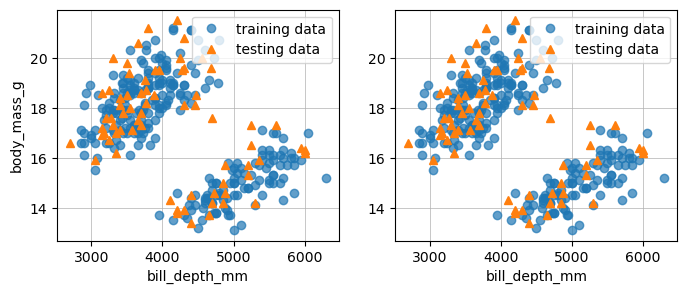

In [6]:
# going to subset data twice to demonstrate a point
fig = plt.figure(figsize=(8, 3))
for i in range(2):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    ax = plt.subplot(1, 2, i+1)
    ax.plot(X_train, Y_train, f'C0o', alpha=0.7, label="training data")
    ax.plot(X_test, Y_test, f'C1^', label="testing data")
    ax.set_xlabel(f"{target_vars[ind[1]]}")
    if i == 0:
        ax.set_ylabel(f"{target_vars[ind[0]]}")
    ax.grid(lw=0.5, zorder=0)
    ax.legend()

---
## b) Data scaling/transformations

If you have't changed my default settings then one thing you can argue is that the units of the selected data are not even the same (one is a length and the other is a weight), so how can we even sensibly/meaningfully compare them? Further, given a ML model depends on data input, would this discrepancy not cause problems for the model? 

A quick answer is that "you can't/shouldn't" and "yes it will do, although the question (and thus the related answer) is probalby much more subtle... Without going into too much detail, it really is also context dependent, and a standard (!?) thing to do is to normalise and scale the data distributions accordingly.

> NOTE: "Standard" does not mean it is the "best" all the time.
>
> I like to try and think of problems from a geometry point of view, and the way I'd phrase the above problem is effectly asking what is the ***metric*** of interest. From a machine learnig point of view, see [information geometry](https://en.wikipedia.org/wiki/Information_geometry) and the textbook by the late [David MacKay](https://www.inference.org.uk/mackay/itila/book.html) for an overview of this maybe.

One way to do this is to ***assume*** (the "assume" part is important) data follows a Gaussian/normal distribution, i.e. for data (random variables) $X$ and $Y$, we have $X \sim \mathcal{N}(\mu_X, \sigma_X)$ and $Y \sim \mathcal{N}(\mu_Y, \sigma_Y)$. While each of the data sets would have their own mean and standard deviations $\mu$ and $\sigma$, we can remove the individual the mean and scale by the standard deviation so the transformed data follow a standardised Gaussian distribution, i.e. $\tilde{X}, \tilde{Y}\sim \mathcal{N}(0, 1)$. Then we can compare them (maybe). The `StandardScaler()` below basically does this. I am going throw the data in individually first to demonstrate some basic syntax.

> NOTE: `sklearn` expects data arrays to have the shape `(n_samples, n_features)`. The 1d arrays I throw in will fail although the warning will ask for a `.reshape`; the one we want is `.reshape(-1, 1)` in this case (it basically just adds an extra dimension to it).

shape before = (342,)
shape after  = (342, 1)
 


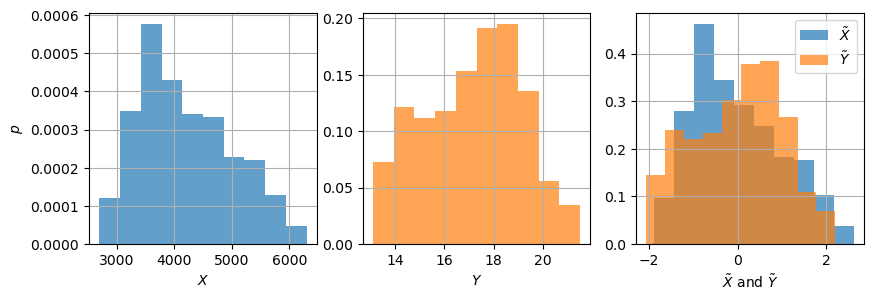

In [7]:
# demonstration of standard scaler: comparisons of PDFs (i.e. histograms)
from sklearn.preprocessing import StandardScaler

X = df[target_vars[ind[0]]].values  # actually load the data into memory
Y = df[target_vars[ind[1]]].values

# sklearn syntax: expects (n_samples, n_features), reshape below is needed
print(f"shape before = {X.shape}")
X = X.reshape(-1, 1)
print(f"shape after  = {X.shape}")
print(" ")
Y = Y.reshape(-1, 1)

# initialise scaler, then fit, and then transform
scaler_X = StandardScaler()
scaler_X.fit(X)   # data is n samples 1 feature
X_scale = scaler_X.transform(X)
scaler_Y = StandardScaler()
scaler_Y.fit(Y)
Y_scale = scaler_Y.transform(Y)
    
fig = plt.figure(figsize=(10, 3))

# raw unscaled histograms
ax = plt.subplot(1, 3, 1)
ax.hist(X, density=True, color="C0", alpha=0.7)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$p$")
ax.grid()

ax = plt.subplot(1, 3, 2)
ax.hist(Y, density=True, color="C1", alpha=0.7)
ax.set_xlabel(r"$Y$")
ax.grid()

ax = plt.subplot(1, 3, 3)
ax.hist(X_scale, density=True, color="C0", alpha=0.7, label=r"$\tilde{X}$")
ax.hist(Y_scale, density=True, color="C1", alpha=0.7, label=r"$\tilde{Y}$")
ax.grid()
ax.set_xlabel(r"$\tilde{X}$ and $\tilde{Y}$")
ax.legend();

Hopefully you are convinced that it would be ridiculous to try and plot the left and middle one together on the same plot given the disparity of scales.

The syntax below does multiple things at the same time.

> NOTE: `sklearn` expects data arrays to have the shape `(n_samples, n_features)`, so I may need to be a bit careful about how I jam the two arrays together. I avoid it completely by just reloading the relevant data, but the commented code shows another way (I can think of at least five other ways to do it).

data shape is (342, 2), already of right form
 


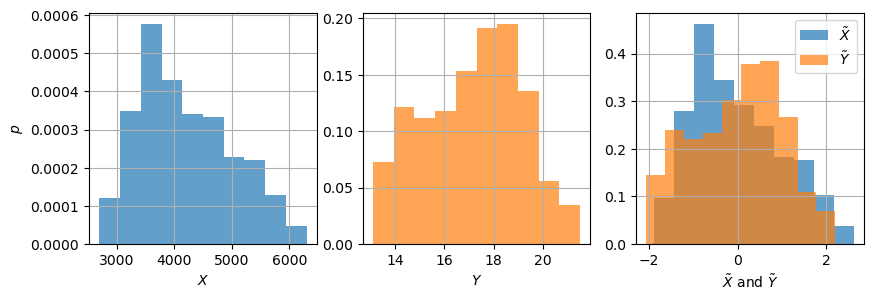

In [8]:
# reload the data
data = df[[target_vars[ind[0]], target_vars[ind[1]]]].values
print(f"data shape is {data.shape}, already of right form")
print(" ")

# could also stack the two arrays together
# X = df[target_vars[ind[0]]].values.reshape(-1, 1)
# Y = df[target_vars[ind[1]]].values.reshape(-1, 1)
# data = np.concatenate((X, Y), axis=-1)  # stack at the feature axis which is the last one

# don't even bother defining the scaler object
data_scale = StandardScaler().fit_transform(data)

fig = plt.figure(figsize=(10, 3))

# raw unscaled histograms
ax = plt.subplot(1, 3, 1)
ax.hist(data[:, 0], density=True, color="C0", alpha=0.7)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$p$")
ax.grid()

ax = plt.subplot(1, 3, 2)
ax.hist(data[:, 1], density=True, color="C1", alpha=0.7)
ax.set_xlabel(r"$Y$")
ax.grid()

ax = plt.subplot(1, 3, 3)
ax.hist(data_scale[:, 0], density=True, color="C0", alpha=0.7, label=r"$\tilde{X}$")
ax.hist(data_scale[:, 1], density=True, color="C1", alpha=0.7, label=r"$\tilde{Y}$")
ax.grid()
ax.set_xlabel(r"$\tilde{X}$ and $\tilde{Y}$")
ax.legend();

There are other ways to scale the data; see extended exercises later.

---
## c) Model skill

One more thing we need before talking cross-validation. If we regard ML as finding a model $f$ that maps inputs $X$ to outputs $Y$ (i.e. regression), then by the "best model" we mean some $f$ that minimises the ***mismatches*** between predictions $\hat{Y}$ and $Y$. The problem then ultimately depends on what you define as the mismatch. A standard choice is the $L^p$ family of norms given by
\begin{equation*}
    \|\hat{Y} - Y\|_{L^p} = \left(\int |\hat{Y} - Y|^p\; \mathrm{d}\mu \right)^{1/p}.
\end{equation*}
The most commonly used ones of these are $L^2$ or ***mean squared error*** (MSE) and $L^1$ or ***mean absolute error*** defined by
\begin{equation*}
    \mathrm{MSE} = \|\hat{Y} - Y\|^2_{L^2} = \int |\hat{Y} - Y|^2\; \mathrm{d}\mu, \qquad \mathrm{MAE} = \|\hat{Y} - Y\|_{L^1} = \int |\hat{Y} - Y|\; \mathrm{d}\mu,
\end{equation*}
where the integral is invariably replaced by sums in contexts encountered in this course.

For the training of the ML model a choice of mismatch (i.e. the ***loss function***, or the ***objective function*** in the classical optimisation literature) would need to be specified, and $L^2$ or MSE is often used. On the other hand, we can also evalute a model's skill using MSE and MAE measures (or any other ones we think are relevant).

> NOTE: Again, "standard" does not necessarily mean best.
>
> $\mathrm{d}\mu$ is related to a "measure"; not going to elaborate what that means except that it is a fundamental object in the theory of probability, and is more fundamental than the "metric".
>
> $L^2$ or MSE is often chosen to be the loss presumably because $L^2$ is differentiable and the resulting space is (presumably) a ***Hilbert space***, which has desirable properties. Not actually sure if this is the intention of most practicioners though...

To see how this works we do need to choose a model, so I am going to choose Linear Regression (`LinearRegression` below) partly to demostrate syntax. Recall that linear regression does
\begin{equation*}
    \hat{Y} = aX + b,
\end{equation*}
where the name of the game is to find $a$ and $b$ such that the $L^2$ mismatches are smallest. Since it is constructed to be a $L^2$ mminimiser we expect the related MSE will be small, but we also note this does not say anything about MAE. We are going to predict $Y$ from $X$; going to throw the whole data in for this one just because.

> NOTE: Here I am not going to standardise the data because it doesn't matter for linear regression (because it's linear, so $a$ and $b$ change but it is just a rescaled linear line).

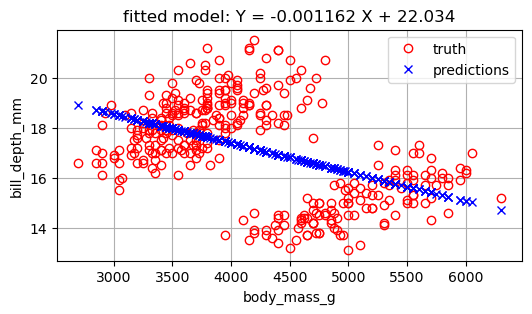

In [9]:
from sklearn.linear_model import LinearRegression

# same syntax as above, (n_samples, n_features)
X = df[target_vars[ind[0]]].values.reshape(-1, 1)
Y = df[target_vars[ind[1]]].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(X, Y, 'ro', fillstyle="none", label="truth")
ax.plot(X, Y_pred, 'bx', label="predictions")
ax.set_xlabel(target_vars[ind[0]])
ax.set_ylabel(target_vars[ind[1]])
ax.grid()
ax.legend()
ax.set_title(f"fitted model: Y = {model.coef_[0, 0]:.6f} X + {model.intercept_[0]:.3f}");

The model is expected to suck in terms of skill because the data is clearly not linear. Below compares the relevant errors as done through `sklearn` as well as a native way of doing this using `numpy`, as well as computing some other relevant statistics.

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import r_regression

# as computed by sklearn
MSE_sklearn = mean_squared_error(Y, Y_pred)
MAE_sklearn = mean_absolute_error(Y, Y_pred)

# as computed by hand
MSE_np = np.mean(np.abs(Y - Y_pred)**2)
MAE_np = np.mean(np.abs(Y - Y_pred))

print(f"MSE from sklearn = {MSE_sklearn:.4f}")
print(f"MSE from numpy   = {MSE_np:.4f}")
print(f"MAE from sklearn = {MAE_sklearn:.4f}")
print(f"MAE from numpy   = {MAE_np:.4f}")
print(" ")
print(f"R^2 score of model = {model.score(X,Y):.4f}")
print(f"correlation coeff of model = {r_regression(X, Y.ravel())[0]:.4f}")
print(" ")

MSE from sklearn = 3.0224
MSE from numpy   = 3.0224
MAE from sklearn = 1.4221
MAE from numpy   = 1.4221
 
R^2 score of model = 0.2227
correlation coeff of model = -0.4719
 


Coinvince yourself the $R^2$ score is consistent that there is not really a linear correlation going on, and the negative linear correlation coefficient is also consistent with the overall shape of the data.

> <span style="color:red">Q.</span> Do the above but scale the data, and convince yourself the same conclusions above effectively holds.
>
> <span style="color:red">Q.</span> Check that the R^2 and linear correlation coefficient computed above coincide with that computed from `scipy` (cf. what was done in OCES 3301).

---
## d) Validation and robustness

Given the randomness in the data and train/test split, two things you may want to ask are:

1. How robust is the model? (Did you get a model with good skill because you got lucky?)
2. How generalisable is your model?

ML models are generally prone to ***over-fitting***, in that it is easy to keep adding complexity into the model, which usually improves the skill over the training data, but fail miserably in the testing data. Going to illustrate a few things one could do to mitigate this a bit.

If you go back to the first graph in the notebook where I coloured the data by `species`, you will notice that `Gentoo` is well-separated from `Adelie` and `Chinstrap`, so if I do a linear regression of those only those it will give me very different results. Below code demonstrates this.

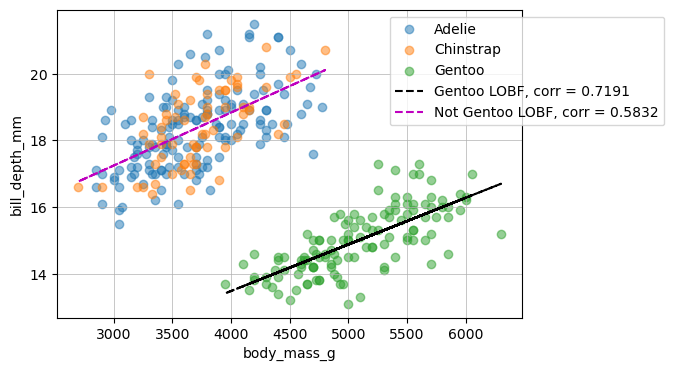

In [11]:
# show difference of regression of Gentoo and (Adelie, Chinstrap)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
for species in np.sort(df["species"].unique()):   # pick out all unique entries under `species`
    ax.scatter(df[df["species"] == species][target_vars[ind[0]]], 
               df[df["species"] == species][target_vars[ind[1]]],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )

# fit gentoo data
X = df[df["species"] == "Gentoo"][target_vars[ind[0]]].values.reshape(-1, 1)
Y = df[df["species"] == "Gentoo"][target_vars[ind[1]]].values.reshape(-1, 1)
model = LinearRegression().fit(X, Y)
ax.plot(X, model.predict(X), 'k--', label=f"Gentoo LOBF, corr = {r_regression(X, Y.ravel())[0]:.4f}")

# fit other data (find NOT gentoos)
X = df[df["species"] != "Gentoo"][target_vars[ind[0]]].values.reshape(-1, 1)
Y = df[df["species"] != "Gentoo"][target_vars[ind[1]]].values.reshape(-1, 1)
model = LinearRegression().fit(X, Y)
ax.plot(X, model.predict(X), 'm--', label=f"Not Gentoo LOBF, corr = {r_regression(X, Y.ravel())[0]:.4f}")

ax.set_xlabel(f"{target_vars[ind[0]]}")
ax.set_ylabel(f"{target_vars[ind[1]]}")
ax.grid(lw=0.5, zorder=0)
le = ax.legend()
le.set_bbox_to_anchor([0.7, 0.8, 0.2, 0.2])

Notice the correlation of both models are positive (as it should be), and is of different sign to the correlation coefficient if all data is used. The example here is a bit contrived in that fitting to the whole data using a linear model is clearly not the best thing to do (given the clear separation by species), but it demonstrates the point that given the inherent randomness in data selection there is likely variations in the model that results. If the model depend sensitively on the data then that's probably not a good thing to have.

Well just like we don't (at least we shouldn't) do one trial and conclude from it (unless there is strong reason to believe the system is strongly deterministic, e.g. some physical systems), then one way to investigate ***robustness/uncertainties*** in model is to do a few of these and take averages if need be. I am going to go further in this case and run a ton of `train_test_split`s, spit out the relevant model parameters, and plot the resulting histogram to get a sense of the pdf.

> NOTE: I am effectively training an ***ensemble*** of models here. We will come back to ensembles in e.g. `06_rf_boosting` (***random forests*** is an ensemble method based on decision trees).

In [12]:
# do a ton of trials of LinearRegression (Y = aX + b) but changing the train_test_split
X = df[target_vars[ind[0]]].values.reshape(-1, 1)
Y = df[target_vars[ind[1]]].values.reshape(-1, 1)

# number of trials and initialise arrays to dump statistics in
n = 100
stats = np.zeros((n, 6))  # a, b, MSE on test data, MAE on test data, r, R2
model = LinearRegression()

for i in range(n):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    model.fit(X_train, Y_train)
    stats[i, 0], stats[i, 1] = model.coef_[0, 0], model.intercept_[0]
    
    Y_pred = model.predict(X_test)
    stats[i, 2] = mean_squared_error(Y_test, Y_pred)
    stats[i, 3] = mean_absolute_error(Y_test, Y_pred)

    stats[i, 4] = model.score(X_test, Y_test)
    stats[i, 5] = r_regression(X_train, Y_train.ravel())[0]

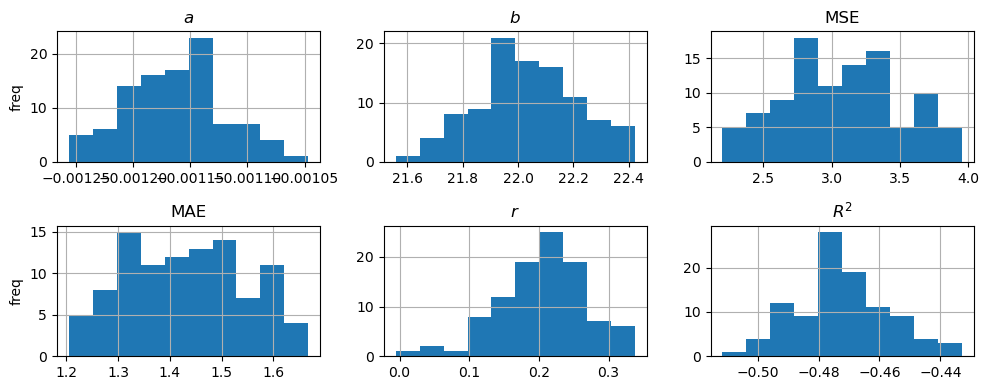

In [13]:
# plot out the above statistics
labels = [r"$a$", r"$b$", "MSE", "MAE", r"$r$", r"$R^2$"]

fig = plt.figure(figsize=(10, 4))
for j in range(6):
    ax = plt.subplot(2, 3, j+1)
    ax.hist(stats[:, j])
    ax.set_title(labels[j])
    ax.grid()
    if j % 3 == 0:
        ax.set_ylabel("freq")
plt.tight_layout()

You can compute the mean and standard deviations of these if you want to, but looking at the histogram the resulting model can be argued to be reasonably robust probably (this would be easier to see if the data was standardised actually). That's not surprising because linear regression is simple enough it probably can't do too many insane things. The same cannot be said of other models.

> <span style="color:red">Q.</span> Do the above but scale the data, and convince yourself the same conclusions above effectively holds.
>
> <span style="color:red">Q.</span> Compute the standard deviations and means (for raw or standardised data, or both if you really want to) and report the model values and statistics of those accordingly using appropriate `print` commands.
>
> <span style="color:red">Q.</span> Explore what happens to the statistics reported above when you change the `test_size` value in `train_test_split`. (Have a think what you would expect if `test_size` were to ***increase*** substantially.)

---
## e) Over-fitting

To demonstrate ***over-fitting*** and thus the need for cross-validation I am going to do **polynomial** regression instead but using `np.polyfit` (could also this through `sklearn.preprocessing.PolynomialFeatures`). In this case my (only) ***hyperparameter*** of the model would be the degree of fitting; linear regression is fitting to a polynomial of degree 1. The goal is to choose one that balances skill with some degree of robustness: in this case I want (relatively) lower MSE/MAE scores, and maybe that the spread of the model statistics is not completely wild. 

I am going to fix the training/testing split to reduce the degree of possible variations.

In [14]:
# Not going reshape because I don't need it when using np.polyfit

X = df[target_vars[ind[0]]].values
Y = df[target_vars[ind[1]]].values

# fix the seed for reproducibility purposes
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

n = 10
MSE_train, MAE_train = np.zeros(n), np.zeros(n)
MSE_test, MAE_test = np.zeros(n), np.zeros(n)
for deg in range(n):
    model = np.polyfit(X_train, Y_train, deg+1)
    Y_pred = np.polyval(model, X_train)
    MSE_train[deg] = mean_squared_error(Y_pred, Y_train)
    MAE_train[deg] = mean_absolute_error(Y_pred, Y_train)
    Y_pred = np.polyval(model, X_test)
    MSE_test[deg] = mean_squared_error(Y_pred, Y_test)
    MAE_test[deg] = mean_absolute_error(Y_pred, Y_test)

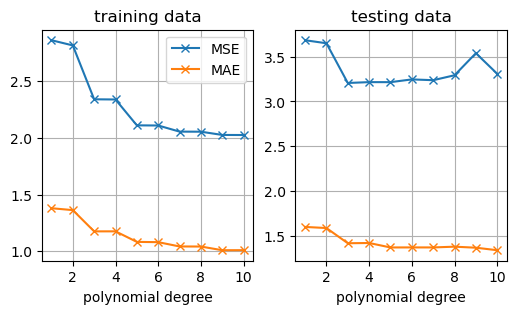

In [15]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(1, n+1), MSE_train, "C0-x", label="MSE")
ax.plot(np.arange(1, n+1), MAE_train, "C1-x", label="MAE")
ax.set_xlabel("polynomial degree")
ax.set_title("training data")
ax.grid()
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(np.arange(1, n+1), MSE_test, "C0-x", label="MSE")
ax.plot(np.arange(1, n+1), MAE_test, "C1-x", label="MAE")
ax.set_xlabel("polynomial degree")
ax.set_title("testing data")
ax.grid()

Above graph suggests that errors in the training are decreasing with increasing polynomial degree, although it is tapering off. This is not surprising as increased complexity generally allows for a better fit. On the other hand, the MSE error has reached some sort of minimum by degree 3. Both of these are symptoms of over-fitting, where the model skill increases with complexity but then fails to generalise as well to unseen data. 

> <span style="color:red">Q.</span> In the above case I am not really extrapolating as such because of how the data is distributed, but if I were extrapolating by feeding it an $X$ beyond the possible range of values I provide for the training then it would probably start returning insane values. Show that this is in fact the case (you don't need to go that far beyond the total range if your polynomial degree is high).
>
> <span style="color:red">Q.</span> Evaluate the robustness of the above conclusion to the choice of random seed. The result should suggest to you that you may or may not want to therefore compute averages somehow to get some sense of the "optimal".

---
## f) Cross-validation

How do we go about selecting a model that has skill and is not too over-fitted? There isn't really one correct answer, but a main point is you probably need to multiple trains to evaluate dependence on the hyper-parameters etc., or take an average model of some sort.

Training on all the data can be costly and one way to explore the dependence on hypoer-parameters is ***$k$-fold*** cross-validation:

* Split data into train and test sets as usual
* Further split training data set into $k$ groups, and train a model on all $k$ of those
* From that, make a decision what it means to be a "best" model (e.g. take the best model from the batch of $k$ models, take some average of the resulting parameters that describe the model, others...)
* Test the "best" model on the testing data set to evaluate over-fitting etc.

Doing this does not avoid over-fitting as such, but it does test for ***sensitivity***, which is an important thing to do given the inherent randomness in the procedures. Below code chooses the "best" model by:

1. The one with the lowest `MSE_test` score (where "test" means the ones from the $k$-fold split).
2. The avergage of all the trained models.

The we evaluate the skill on the withheld test data set.

In [16]:
# load the procedure to split the training data further
from sklearn.model_selection import KFold

X = df[target_vars[ind[0]]].values
Y = df[target_vars[ind[1]]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# initialise a list and dump things in these
k = 5
deg = 5
model = np.zeros((deg+1, k))
MSE_train, MAE_train = np.zeros(k), np.zeros(k)  # don't actually use these but record anyway
MSE_test, MAE_test = np.zeros(k), np.zeros(k)

kf = KFold(n_splits=k)
i = 0

# only do k-fold split on the TRAINING data (the model still never sees the TESTING data)
for train, test in kf.split(X_train):  # these generate a bunch of indices
    model[:, i] = np.polyfit(X_train[train], Y_train[train], deg)
    MSE_train[i] = mean_squared_error(np.polyval(model[:, i], X_train[train]), Y_train[train])
    MAE_train[i] = mean_absolute_error(np.polyval(model[:, i], X_train[train]), Y_train[train])
    MSE_test[i] = mean_squared_error(np.polyval(model[:, i], X_train[test]), Y_train[test])
    MAE_test[i] = mean_absolute_error(np.polyval(model[:, i], X_train[test]), Y_train[test])
    i += 1

In [17]:
# best model from lowest MSE_test, and from an average of those models
model_best1 = model[:, np.where(MSE_test == np.min(MSE_test))[0][0]]
model_best2 = np.mean(model, axis=-1)  # averaging over the "model" dimension

# here we are passing (X_test, Y_test) in
MSE_best1 = mean_squared_error(np.polyval(model_best1, X_test), Y_test)
MSE_best2 = mean_squared_error(np.polyval(model_best2, X_test), Y_test)
MAE_best1 = mean_absolute_error(np.polyval(model_best1, X_test), Y_test)
MAE_best2 = mean_absolute_error(np.polyval(model_best2, X_test), Y_test)

print(f"model_best1 has:")
print(f"  coeffs = {model_best1}")
print(f"  MSE    = {MSE_best1:.6f}")
print(f"  MAE    = {MAE_best1:.6f}")
print(" ")
print(f"model_best2 has:")
print(f"  coeffs = {model_best2}")
print(f"  MSE    = {MSE_best2:.6f}")
print(f"  MAE    = {MAE_best2:.6f}")
print(" ")

model_best1 has:
  coeffs = [-8.75533810e-16  1.96943127e-11 -1.73410469e-07  7.46075052e-04
 -1.56772434e+00  1.30516592e+03]
  MSE    = 3.199619
  MAE    = 1.370188
 
model_best2 has:
  coeffs = [-9.69386804e-16  2.17446592e-11 -1.90998270e-07  8.20046583e-04
 -1.72016374e+00  1.42825764e+03]
  MSE    = 3.218224
  MAE    = 1.368688
 


Several things to be read from the above is that:

* The best model has lower MSE, but the "averaged" model has marginally better performance in MAE, so which is better is somewhat arguable...
* The resulting models are largely the same and has a large value in the last entry, in this case the leading coefficient of $X^5$. (This is probably not a good thing regarding over-fitting...)


> <span style="color:red">Q.</span> Play around with the choice of `k` and `deg`. I would expect the leading coefficient to still be large, which would indicate severe sensitivity if we are doing extrapolation.

The thing to note is over-fitting is potentially more subtle in other models, so it is prudent to do ensembles and/or cross-validate; you should basically assume the ML models you create are probably over-fitted in general, and provide evidence to the degree of over-fitting as appropriate. Later notebooks will demonstrate cross validation and testing for robustness sporadically, but the comprehensive exploration will largely be left as exercises.

> NOTE: There is an easier function `model_selection.cross_val_score` that could be used, but that requires an sklearn estimator object and doesn't play too well here for linear regression (partly because `LinearRegression` is too simple). We will use that briefly when we come to `03_lin_models`.

### <span style="color:red">Comments on over-fitting and robustness of model is expected of all the assignments that are to be handed in.</span> 
1. A portion of the marks under "coding" and marks under "science" will be given for (cross-)validation and related evaluations for model skill and robustness/sensitivity to hyper-parameters, data splitting etc., so you automatically lose quite a lot of marks if you don't do it (cf. referencing: no one likes doing it as such, but it needs to be done).
3. Saying you've done (cross-)validation but without providing numerical evidence will be treated as if no (cross-)validation was in fact performed.
4. An ensemble calculation of about 5 to 10 would be minimally expected (given you are not expected to be creating models that are large and thus slow to run).

----------------
# More involved exercises with this notebook

## 1) Use of `pipeline`

#### (May help with all upcoming assignments.) 

A whole load of the things above can be packaged in one go using [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Redo some of the above using those instead; this may be useful to package up for assignments later.

## 2) Other ways of scaling

Have a look at [here](https://scikit-learn.org/stable/api/sklearn.preprocessing.html) and explore other ways of scaling the data.

You could also try scaling things according to non-Gaussian pdfs, but you may need to do this yourself. Could also consider ***non-dimensionalisation*** based on specific processes (e.g. if you've done my OCES 2003 you would have seen things like the Rossby/Reynolds/Rayleigh/Ekman number; this may show up in the extra material of this course).

## 3) $L^1$ minimising linear regression

This was previously posted as a (hard-ish) problem to do in OCES 3301. Linear regression by default do $L^2$ (mean squared error or MSE) minimisation, but that says nothing about the $L^1$ (mean absolute error or MAE), or indeed other norms. See how you would create a $L^1$ minimising linear regression predictor, and show the resulting object does seem to minimise $L^1$, reduces weighting on the outliers, but says nothing about the $L^2$ or other errors.

I would do it (and have done it beofre) through `scipy.optimize`.